# Stat 201 Project

## Introduction

Higher education institutions are continually striving to improve student retention and academic success. For this purpose, a comprehensive dataset has been collected, amalgamating information from various disjoint databases related to students enrolled in different undergraduate degree programs in an effort to decrease the failure and dropout rate of students. The institution this data set was taken from offers a wide range of programs, encompassing a diverse range of disciplines, including agronomy, design, education, nursing, journalism, management, social service, and technologies. Higher education has the potential to allow significantly different career paths for individuals who pursue a university or college degree but not every student is well supported in these educational institutes. Addressing student dropout rates is a critical concern. This statistical research endeavour seeks to investigate a specific aspect of this challenge, namely whether the dropout rate among students whose parents have received higher-level education exceeds that of students whose parents have not attained such educational qualifications. 

- Background:

The research question at hand is rooted in the persistent challenge of student dropout rates within higher education institutions. It specifically delves into the potential influence of parental educational backgrounds on student retention. While higher education offers students the opportunity for personal and professional growth, not all students navigate their academic journey without obstacles.

The influence of parental education on student outcomes has been a subject of interest for years. This research question seeks to contribute to this body of knowledge by focusing on the connection between parents' educational attainment and student dropout rates. By doing so, it aims to identify a potential factor that could impact the academic success and persistence of students.

- Significance:

The significance of this project lies in its potential to shed light on a crucial aspect of student dropout rates within the context of parental education. If the data uncovers a statistically significant difference between the two groups, it could inform policies and interventions to better support students, particularly those with parents who have not received higher-level education. The ramifications extend beyond the academic realm, as the findings may have implications for social and economic equity. A deeper understanding of this relationship can help institutions tailor their support systems and interventions more effectively, potentially levelling the playing field for all students, regardless of their parental educational backgrounds.

- Dataset used: (https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

The above dataset will be used in this project, the data includes a large number of students with numerous variables that ilucidate each student's unique personal background and their success or failure at the institution.

### Research Question

**Is the dropout rate of students with parents that recieved higher level education greater than those whose parents have not recieved higher level education?**
- higher level education refers to education beyond the highschool level
- parents are considered to recieve higher level education as long as *one* parent have recived higher level eduction

$H_0: p_1 = p_2$  
$H_a: p_1 > p_2$  
$p_1$: proportion of student dropout with parents that recieved higher level education  
$p_2$: proportion of student dropout with parents that have **not** recieved higher level education

Hypothesis testing will be conducted with $\alpha = 1$.

### Variables of Interest:

Mother's and Father's qualifications, Admission grade and Target variables.


Via the mentioned variables and statistical inference, we can provide valuable insights for universities and colleges to enhance their support systems, ultimately improving the overall success and retention of students across a range of undergraduate degree programs.

## Preliminary Analysis

This section will include:
- Reading data from UCI database
- Wrangling, analyzing, and plotting relevant data
    - Classifying parents' education levels
    - Calculating relative dropout rates
- Computing point estimates

In [6]:
# Constants
DATASET_URL <- "https://raw.githubusercontent.com/MehrshadEsm/stat-201-project/main/data.csv"
DATA_FIELDS <- c("Mother's qualification", "Father's qualification", "Admission grade") 

In [13]:
# Load liraries and set seed
set.seed(1234)
library(tidyverse)
library(tidymodels)
library(infer)
library(ggplot2)

### Reading and Cleaning Data

The `Target` describes 3 possible outcomes of a student, they either "Graduate", "Dropout", or stay "Enrolled". This analysis will focus on the proportion of students that have dropped out specifically. 

Moreover, `Mother's qualification` and `Father's qualification` describe the parents education level, where each number corresponds to an education experience (details [here](#Wrangling-and-Visualizing-Data)). Note that the order is arbitrary, and it not indicative of education level!

The admission grade of the student is also a significant variable that can shed further insight into our investigation, so we keep that in the table. 

In [42]:
# load data from url
student_data_raw <- read_delim(DATASET_URL, delim = ";")

# select target columns
student_data <- 
    student_data_raw |>
    select(Target, all_of(DATA_FIELDS))

head(student_data)
cat("[Table 1] Unwrangled student data with relevant variables")

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Target,Mother's qualification,Father's qualification,Admission grade
<chr>,<dbl>,<dbl>,<dbl>
Dropout,19,12,127.3
Graduate,1,3,142.5
Dropout,37,37,124.8
Graduate,38,37,119.6
Graduate,37,38,141.5
Graduate,37,37,114.8


[Table 1] Unwrangled student data with relevant variables

### Wrangling and Visualizing Data 

We need to classify parents education level into two categories, those who have recieved higher education, and those who have not recieved higher education. Using the UCI dataset description, we classify the education levels numerically as follows
- **Recieved higher education:**  
**2** - Bachelor's Degree, 
**3** - Degree, 
**4** - Master's, 
**5** - Doctorate, 
**22** - Technical-professional course, 
**40** - degree (1st cycle), 
**41** - Specialized higher studies course, 
**42** - Professional higher technical course, 
**43** - Master (2nd cycle), 
**44** - Doctorate (3rd cycle),
**39** - Technological specialization course.

- **Have not recieved higher education:**  
**1** - Secondary Education, 
**9** - 12th Year of Schooling - Not Completed,
**10** - 11th Year of Schooling - Not Completed, 
**11** - 7th Year, 
**12** - 11th Year of Schooling,
**14** - 10th Year of Schooling 18, 
**19** - Basic Education 3rd Cycle (9th/10th/11th Year), 
**26** - 7th year of schooling, 
**27** - 2nd cycle of the general high school course, 
**29** - 9th Year of Schooling - Not Completed, 
**30** - 8th year of schooling, 
**35** - Can't read or write, 
**36** - Can read without having a 4th year of schooling, 
**37** - Basic education 1st cycle (4th/5th year), 
**38** - Basic Education 2nd Cycle (6th/7th/8th Year). 

- **Outliers (We ignore these)**:  
**34** - Unknown , 
**6** - Frequency of Higher Education 

Below is a table of the results:

In [43]:
higher_edu = c(2, 3, 4, 5, 22, 40, 41, 42, 43, 44, 39)
not_higher_edu = c(1, 9, 10, 11, 12, 14, 19, 26, 27, 29, 30, 35, 36, 37, 38)
outliers = c(34, 6)

student_data_edu <- 
    student_data |>
    filter(!(`Mother's qualification` %in%  outliers | `Father's qualification` %in%  outliers)) |>
    mutate(one_higher_edu  = ((`Mother's qualification` %in%  higher_edu) | (`Father's qualification` %in%  higher_edu)),
           both_higher_edu = ((`Mother's qualification` %in%  higher_edu) & (`Father's qualification` %in%  higher_edu)),
           none_higher_edu = (!(`Mother's qualification` %in%  higher_edu) & !(`Father's qualification` %in%  higher_edu)))

head(student_data_edu)
cat("[Table 2] Wrangled summary of student dropout rates with classification")

Target,Mother's qualification,Father's qualification,Admission grade,one_higher_edu,both_higher_edu,none_higher_edu
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
Dropout,19,12,127.3,FALSE,FALSE,TRUE
Graduate,1,3,142.5,TRUE,FALSE,FALSE
Dropout,37,37,124.8,FALSE,FALSE,TRUE
Graduate,38,37,119.6,FALSE,FALSE,TRUE
Graduate,37,38,141.5,FALSE,FALSE,TRUE
Graduate,37,37,114.8,FALSE,FALSE,TRUE


[Table 2] Wrangled summary of student dropout rates with classification

Next, we also summarize the data into a point-estimate of the dropout rates.

In [45]:
# proportion table
student_dropout_props_one <-
    student_data_edu |>
    group_by(one_higher_edu) |>
    summarize(dropout_prop = sum(Target == "Dropout") / n(),
              size = n(), 
              grade = mean(`Admission grade`))

student_dropout_props_both <-
    student_data_edu |>
    group_by(both_higher_edu) |>
    summarize(dropout_prop = sum(Target == "Dropout") / n(),
              size = n(), 
              grade = mean(`Admission grade`))

student_dropout_props_none <-
    student_data_edu |>
    group_by(none_higher_edu) |>
    summarize(dropout_prop = sum(Target == "Dropout") / n(),
              size = n(), 
              grade = mean(`Admission grade`))

student_dropout_props_one
cat("[Table 3] Summary table of student dropout proportions")

student_dropout_props_both
cat("[Table 3] Summary table of student dropout proportions")

student_dropout_props_none
cat("[Table 3] Summary table of student dropout proportions")

one_higher_edu,dropout_prop,size,grade
<lgl>,<dbl>,<int>,<dbl>
FALSE,0.3059873,3474,126.5741
TRUE,0.3125778,803,129.6268


[Table 3] Summary table of student dropout proportions

both_higher_edu,dropout_prop,size,grade
<lgl>,<dbl>,<int>,<dbl>
FALSE,0.3056247,4018,126.8266
TRUE,0.3320463,259,132.1216


[Table 3] Summary table of student dropout proportions

none_higher_edu,dropout_prop,size,grade
<lgl>,<dbl>,<int>,<dbl>
FALSE,0.3125778,803,129.6268
TRUE,0.3059873,3474,126.5741


[Table 3] Summary table of student dropout proportions

At a glance, we can see that students with parents that have recieved higher education actually are more likely to drop out. The difference in dropout rates is actually quite small, and
This seems to match with out intial assumption; however, we would need to perform more tests to verify the accuracy and validity of our sample point-estimates.

### Visualize Data


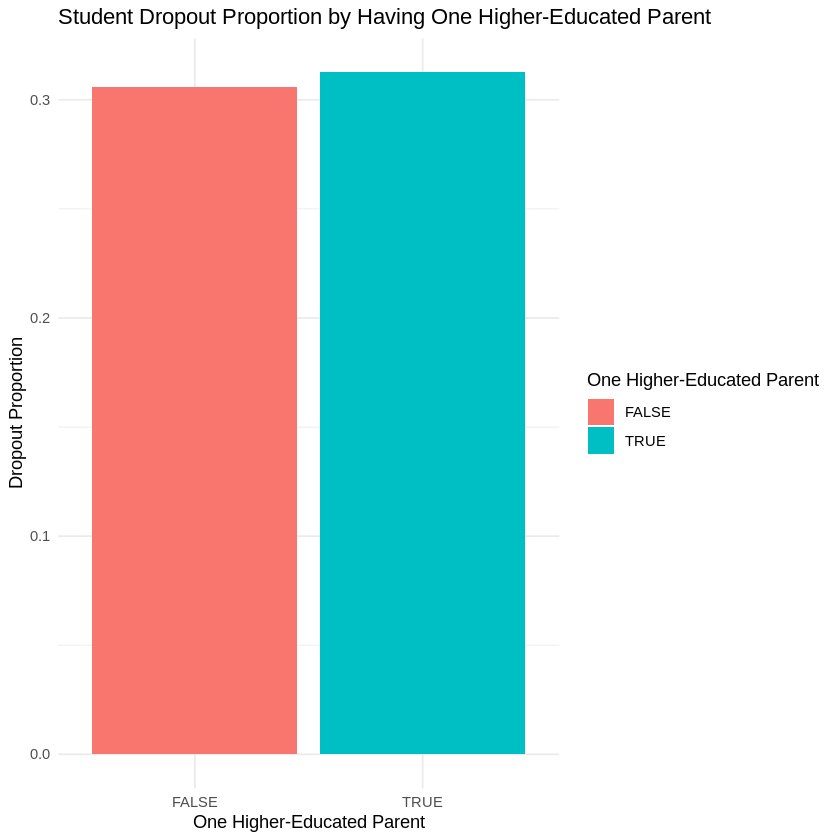

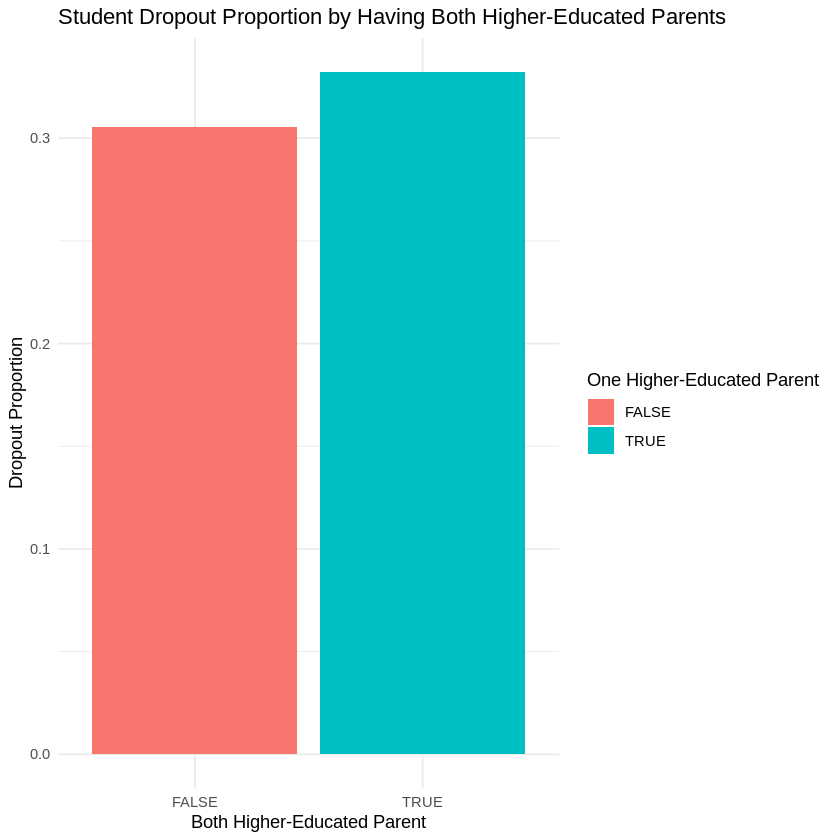

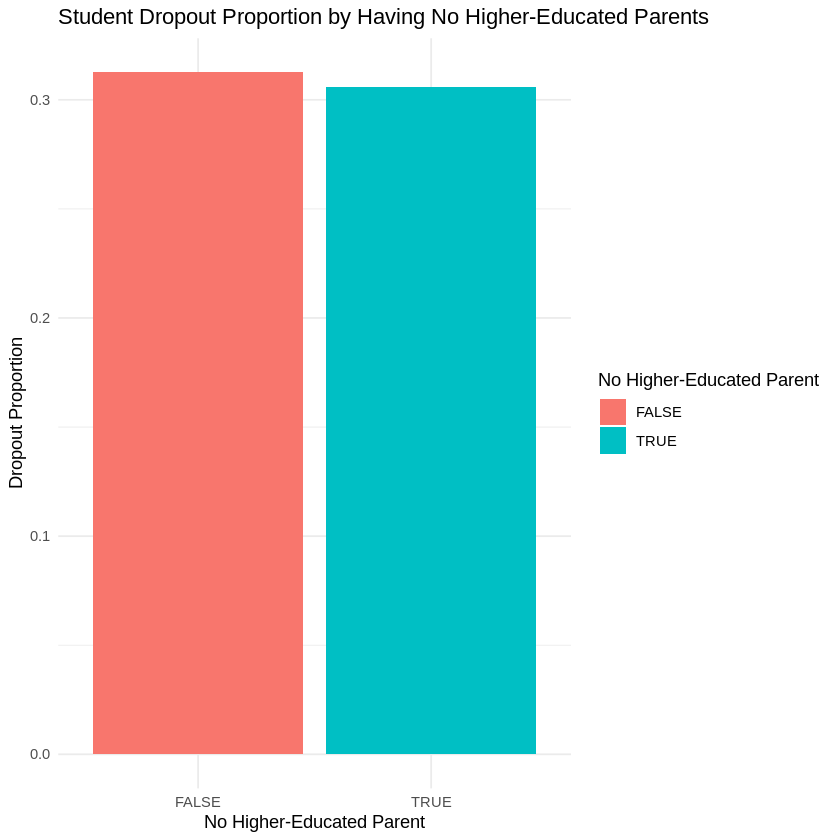

In [49]:
library(ggplot2)

plot_one <- ggplot(data = student_dropout_props_one, aes(x = factor(one_higher_edu), y = dropout_prop, fill = factor(one_higher_edu))) +
  geom_bar(stat = "identity") +
  labs(title = "Student Dropout Proportion by Having One Higher-Educated Parent",
       x = "One Higher-Educated Parent",
       y = "Dropout Proportion") +
  scale_fill_discrete(name = "One Higher-Educated Parent") +
  theme_minimal()

plot_one

plot_two <- ggplot(data = student_dropout_props_both, aes(x = factor(both_higher_edu), y = dropout_prop, fill = factor(both_higher_edu))) +
  geom_bar(stat = "identity") +
  labs(title = "Student Dropout Proportion by Having Both Higher-Educated Parents",
       x = "Both Higher-Educated Parent",
       y = "Dropout Proportion") +
  scale_fill_discrete(name = "One Higher-Educated Parent") +
  theme_minimal()

plot_two

plot_three <- ggplot(data = student_dropout_props_none, aes(x = factor(none_higher_edu), y = dropout_prop, fill = factor(none_higher_edu))) +
  geom_bar(stat = "identity") +
  labs(title = "Student Dropout Proportion by Having No Higher-Educated Parents",
       x = "No Higher-Educated Parent",
       y = "Dropout Proportion") +
  scale_fill_discrete(name = "No Higher-Educated Parent") +
  theme_minimal()

plot_three
# box and whisker-plot
# edit the true & false
# facet-grid

## Methods and Results
The previous sections will carry over to your final report (you’ll be allowed to improve them based on feedback you get). Begin this Methods section with a brief description of “the good things” about this report – specifically, in what ways is this report trustworthy?

Continue by explaining why the plot(s) and estimates that you produced are not enough to give to a stakeholder, and what you should provide in addition to address this gap. Make sure your plans include at least one hypothesis test and one confidence interval. If possible, compare both the bootstrapping and asymptotics methods.

Finish this section by reflecting on how your final report might play out:

What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

### Expectations/Impacts/Future Questions

It is expected to find that student with educated parents have a higher GDP than students with uneducated parents. To compare, we exclude scholarship holders from our data as student with scholarships are expected to have higher GDP compare to normal students. We will train the data set we have as a sample from the population. After we get the sample mean, we will estimate the 95% confidence interval about the sample mean we have to see how confident we are about the estimate.

Such finding could have impact on future study that trying to estimate the family unit parameters based on educational background of the family members.

Future questions this could lead to is society related questions, if our assumption is ture, which is that educated parents are likely to have child that successfully graduate from university than uneducated parents, then is university one of the factor than may cause social class differences and gaps? Another type of questions that this study could lead to is family education questions: Again, if our assumption is ture, is it still worthy for uneducated parents sents their children to university?

## Discussion

## References

https://oa.mg/work/10.1007/978-3-030-72657-7_16


At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.

assigned to review a different group’s proposal. This allows your group to collectively see a larger variety of proposals.)